## Analysing model training

In [13]:
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import config_util
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(config_util)
reload(data_util)
from value_decoder import ValueDecoder
from decoder import Decoder
from encoder import Encoder


In [14]:
import torch
import numpy as np
import sympy as sp
from util import prods_to_eq, logits_to_prefix, logits_to_prods
from config_util import dict_to_config, load_config
from data_util import data2input, load_dataset, calc_priors_and_means, create_dataloader
from debug_util import plot_onehot
import wandb
from model import GrammarVAE
import yaml
from matplotlib import pyplot as plt
torch.manual_seed(41)

# Load dataset
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath=datapath, name='dataset_240817_2')
data_syntax = np.concatenate([syntax, consts[:, :, np.newaxis]], axis=-1)
value_transform = lambda x: torch.arcsinh(x)*0.1
val_transformed = value_transform(torch.tensor(val)).detach().numpy()

# Load model
run = 'koxmwjg7'
wandb_cache_path = f'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/wandb_cache'
with wandb.restore('model.pth', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as io:
    name = io.name
checkpoint = torch.load(name, map_location='cpu')

# Read the model parameters from the WandB config.yaml file
with wandb.restore('config.yaml', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as config_file:
    config = yaml.safe_load(config_file)
    cfg = {k: v['value'] for k, v in list(config.items()) if k not in ['wandb_version', '_wandb']}
    cfg = dict_to_config(cfg)

vae_model = GrammarVAE(cfg)
vae_model.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [3]:
# Count total parameters in vae_model
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Total number of parameters in vae_model: {total_params}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in vae_model: {trainable_params}")

# Count parameters in encoder
encoder_params = sum(p.numel() for p in vae_model.encoder.parameters())
print(f"Number of parameters in encoder: {encoder_params}")

# Count parameters in decoder
decoder_params = sum(p.numel() for p in vae_model.decoder.parameters())
print(f"Number of parameters in decoder: {decoder_params}")

# Count parameters in value_decoder
value_decoder_params = sum(p.numel() for p in vae_model.value_decoder.parameters())
print(f"Number of parameters in value_decoder: {value_decoder_params}")


Total number of parameters in vae_model: 700046
Total number of trainable parameters in vae_model: 700046
Number of parameters in encoder: 93024
Number of parameters in decoder: 46282
Number of parameters in value_decoder: 560740


In [4]:
from data_util import create_dataloader

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240817_2', cfg, value_transform=lambda x: torch.arcsinh(x)*0.1)
assert all([config['dataset_hashes']['value'][key] == hashes[key] for key in config['dataset_hashes']['value']]), "Error: Using different dataset than used for training."

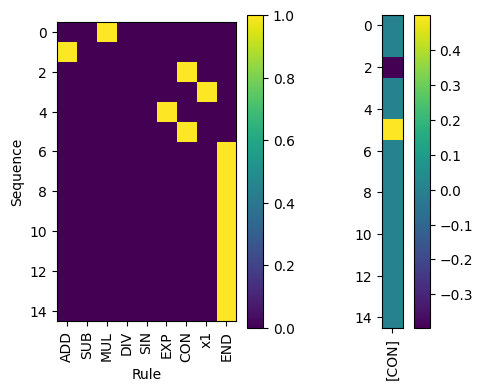

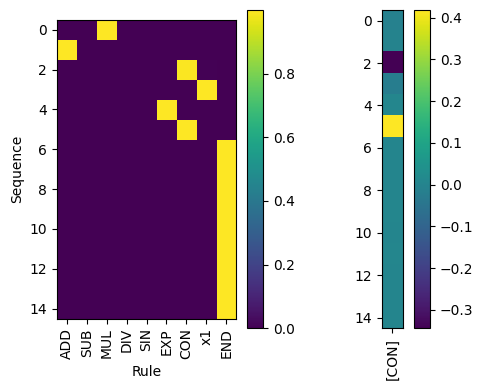

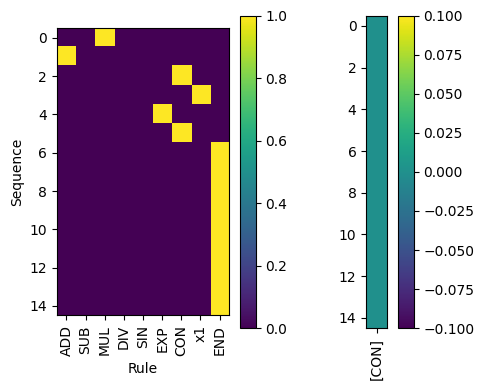

In [213]:
i = 10
x = data2input(data_syntax[i, ...])
# x = all_x[i, ...].unsqueeze(0)

logits, values_pred = vae_model.forward(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))


# Create a matrix where the argmax column is 1 and everything else is 0 for each row
logits_numpy = logits.squeeze(0).detach().numpy().copy()
argmax_matrix = np.zeros_like(logits_numpy)
argmax_indices = np.argmax(logits_numpy, axis=1)
argmax_matrix[np.arange(logits_numpy.shape[0]), argmax_indices] = 1

# Plot the argmax matrix
plot_onehot(argmax_matrix, syntax_cats, apply_softmax=False, figsize=(5, 4))


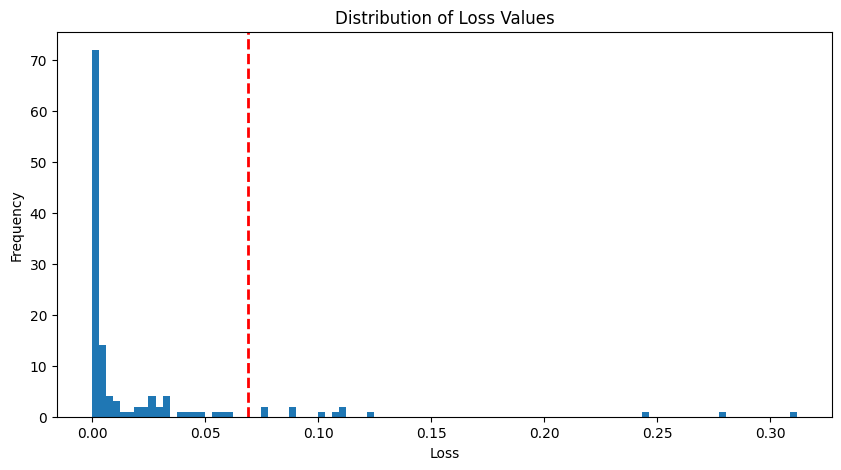

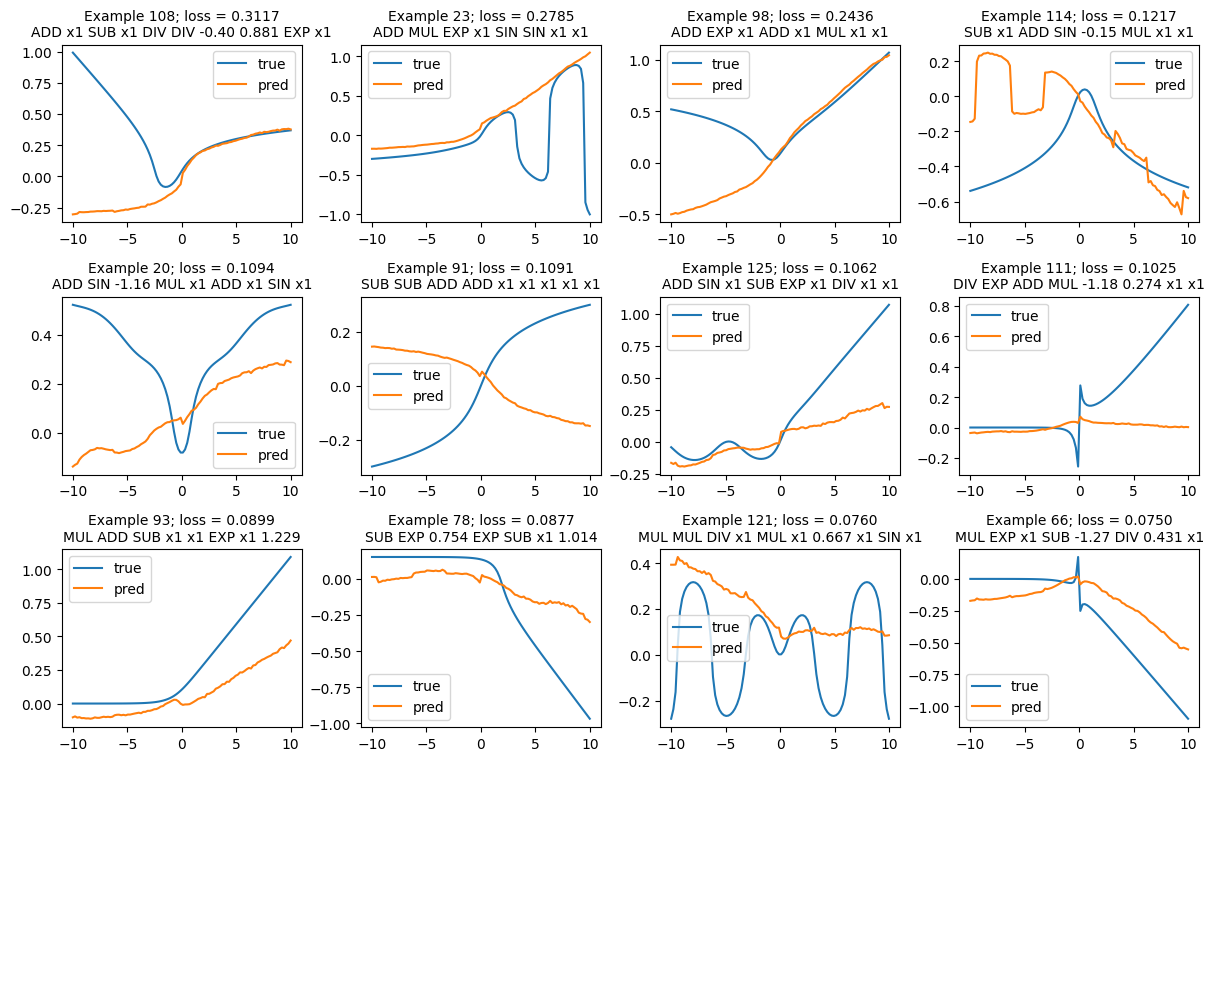

In [6]:
from grammar import GCFG

i = 2
N = 128
data_loader = test_loader
x = data_loader.dataset.dataset[data_loader.dataset.indices][0][i:i+N, ...]
values_true = data_loader.dataset.dataset[data_loader.dataset.indices][3][i:i+N, ...]

# Calculate predictions
_, values_pred = vae_model.forward(x)

# Calculate loss for each example
mse = torch.nn.MSELoss(reduction='none')
loss = mse(values_pred, values_true).mean(axis=1)

# Calculate mean and standard deviation of loss
loss_mean = loss.mean()
loss_std = loss.std()

# Set threshold (e.g., 1 standard deviation above mean)
threshold = loss_mean + 1 * loss_std

# Sort indices by loss in descending order
sorted_indices = torch.argsort(loss, descending=True)

# Plot histogram of loss values
plt.figure(figsize=(10, 5))
plt.hist(loss.detach().numpy(), bins=100)
plt.axvline(threshold.detach().numpy(), color='r', linestyle='dashed', linewidth=2)
plt.title('Distribution of Loss Values')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

# Plot function values for highest-loss examples above threshold
num_plots = 16  # Limit to 16 plots
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 2.5 * num_rows), squeeze=False)
fig.tight_layout(pad=5.0)

plot_count = 0
for i in range(len(sorted_indices)):
    if plot_count >= num_plots:
        break
    
    idx = sorted_indices[i]
    if loss[idx] < threshold:
        continue
    
    row = plot_count // num_cols
    col = plot_count % num_cols
    
    y_true = values_true[idx, ...]
    y_pred = values_pred[idx, ...]
    
    # Plot function values
    axs[row, col].plot(val_x, y_true.squeeze().detach().numpy(), label='true')
    axs[row, col].plot(val_x, y_pred.squeeze().detach().numpy(), label='pred')
    axs[row, col].legend()
    prods = logits_to_prods(x[idx, ...].squeeze(0).T, GCFG, sample=False)
    eq = [s[:min(5, len(s))] for s in prods_to_eq(prods)]
    eq_str = ' '.join(eq)
    axs[row, col].set_title(f'Example {idx.item()}; loss = {loss[idx].item():.4f}\n{eq_str}', fontsize=10)
    
    plot_count += 1

# Hide any unused subplots
for i in range(plot_count, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [274]:
y_true, y_pred
mse = torch.nn.MSELoss(reduction='mean')
mse(torch.tensor(y_true).unsqueeze(0), torch.tensor(y_pred).unsqueeze(0))

tensor(0.0050)

In [8]:
x.shape

torch.Size([1, 10, 15])

In [11]:
values_pred.shape

torch.Size([128, 100])

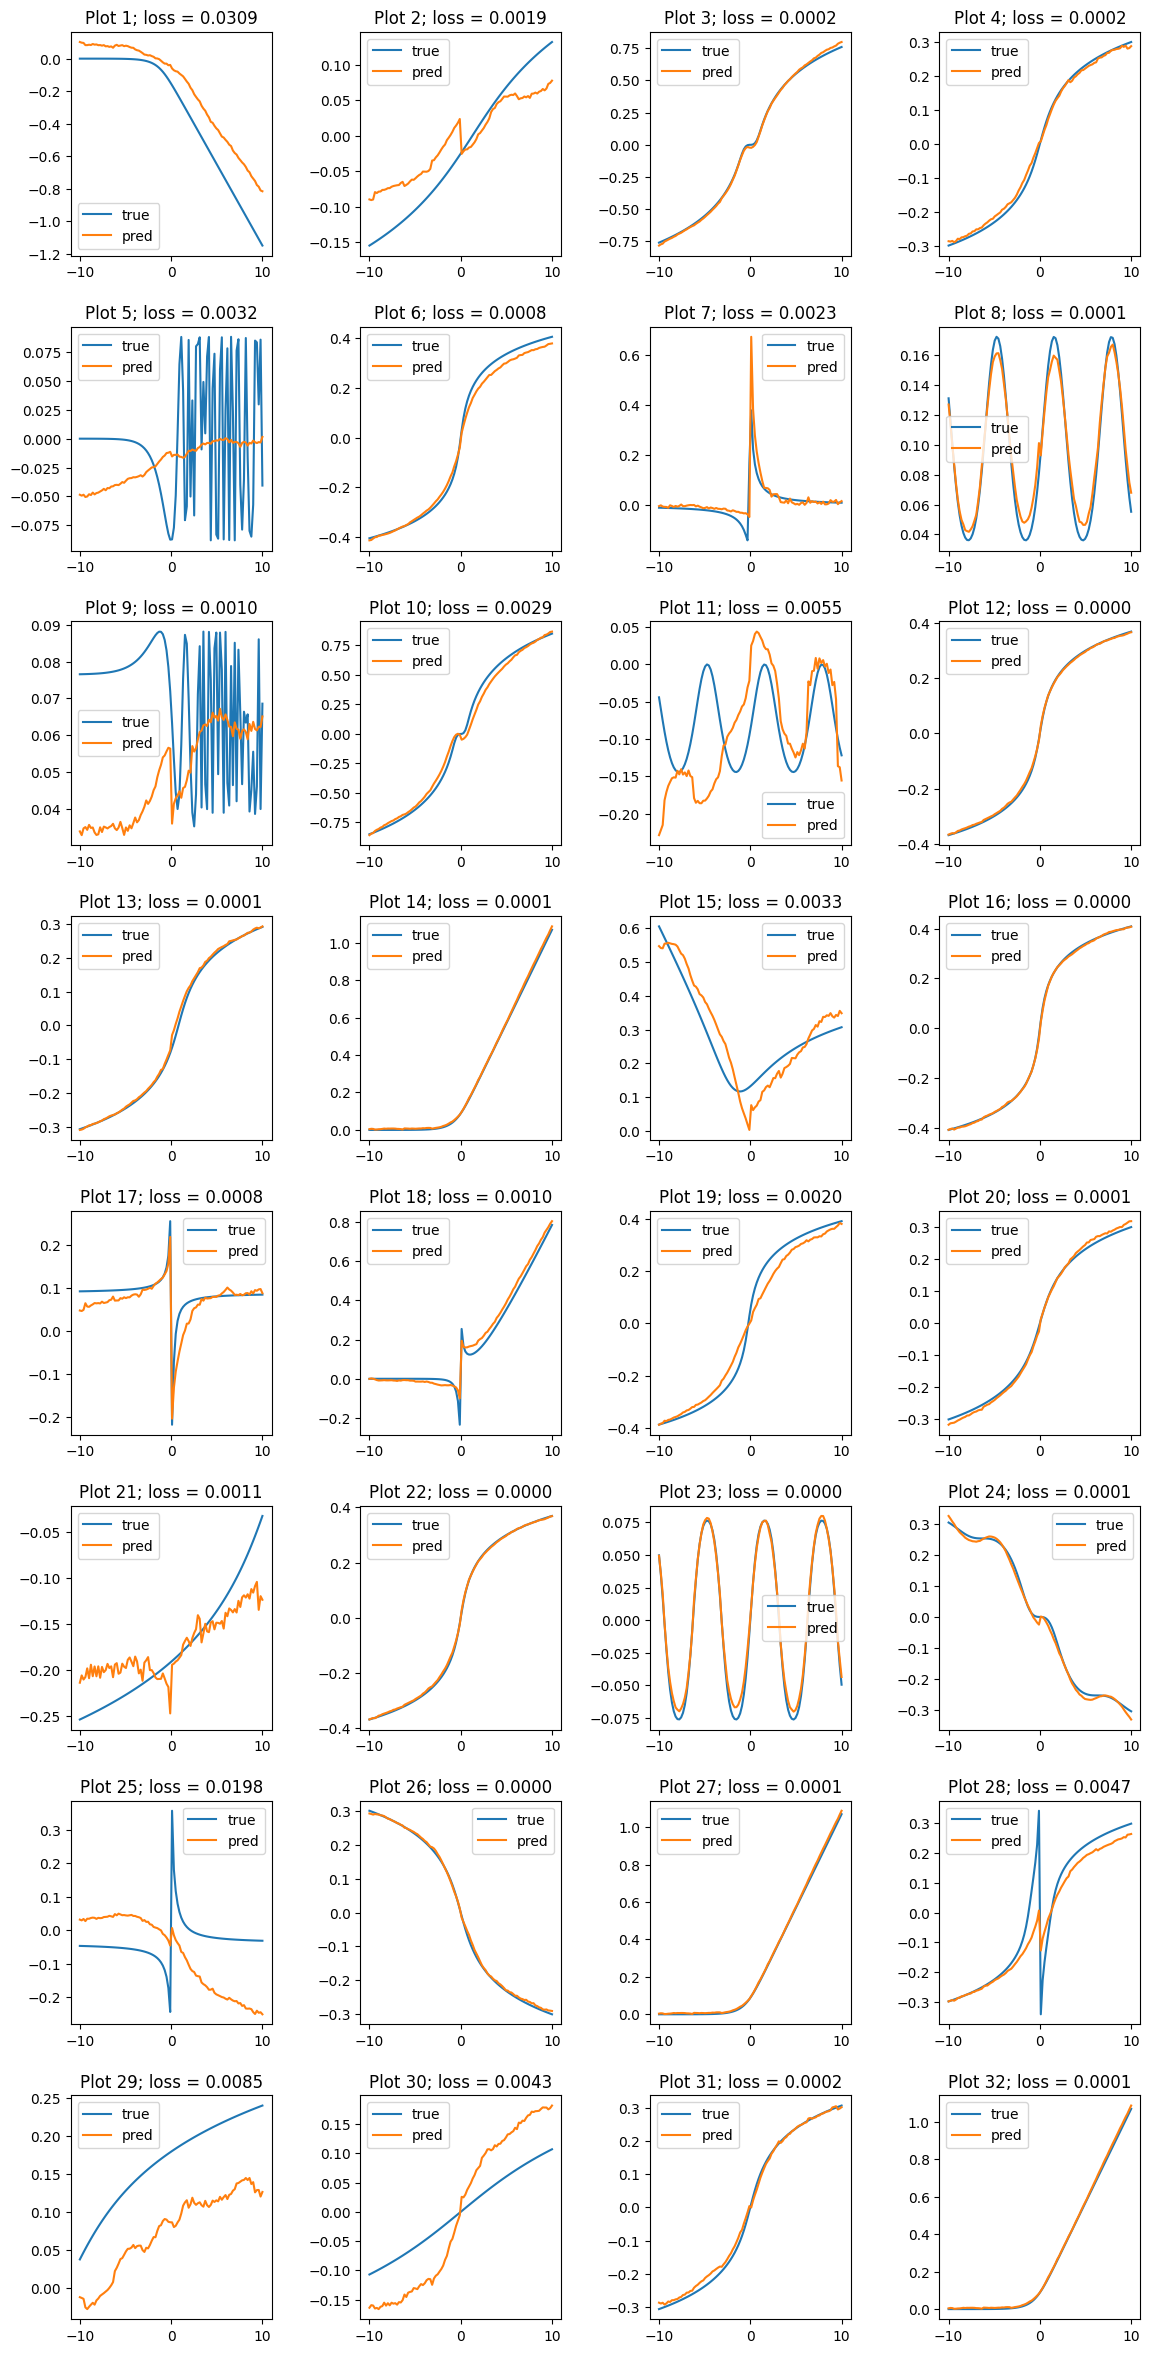

In [12]:
## Check value prediction
i = 0
N = 32
data_loader = train_loader
x = data_loader.dataset.dataset[data_loader.dataset.indices][0][i:i+N, ...]
values_true = data_loader.dataset.dataset[data_loader.dataset.indices][3][i:i+N, ...]

# Calculate predictions
_, values_pred = vae_model.forward(x)


num_plots = N
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division to ensure all plots are included

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows), squeeze=False)
fig.tight_layout(pad=3.0)

for i in range(num_plots):
    row = i // num_cols
    col = i % num_cols
    y_true = values_true[i, ...]
    y_pred = values_pred[i, ...]

    loss = torch.nn.MSELoss()(y_true, y_pred)

    axs[row, col].plot(val_x, y_true.squeeze().detach().numpy(), label='true')
    axs[row, col].plot(val_x, y_pred.squeeze().detach().numpy(), label='pred')
    axs[row, col].legend()
    axs[row, col].set_title(f'Plot {i+1}; loss = {loss.item():.4f}')

# Hide any unused subplots
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.show()

In [296]:
from importlib import reload
import grammar
reload(util)
reload(grammar)
from util import logits_to_prods, prods_to_eq
from grammar import GCFG

prods = logits_to_prods(logits.squeeze(0), GCFG, sample=False)
print(prods)
eq = prods_to_eq(prods)
print(eq)




[S -> 'DIV' S S, S -> 'DIV' S S, S -> 'x1', S -> 'x1', S -> 'SIN' S, S -> 'SIN' S, S -> '1.7224293947219849']
['DIV', 'DIV', 'x1', 'x1', 'SIN', 'SIN', '1.7224293947219849']
